In [ ]:
! pip install deepface

In [22]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from deepface import DeepFace
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [ ]:
def generate_dataset(dataset_path, output_file):
    data = []  # To store all extracted data

    for folder in tqdm(os.listdir(dataset_path)):  # Iterate through subfolders
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):  # Iterate through images in the folder
                img_path = os.path.join(folder_path, image_file)
                try:
                    embedding_objs = DeepFace.represent(img_path=img_path, model_name="ArcFace")
                    if embedding_objs:  # Ensure embeddings are not empty
                        embeddings = embedding_objs[0]['embedding']
                        data.append([folder, image_file] + embeddings)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # Save the dataset as CSV
    columns = ["label", "file_name"] + [f"feature{i+1}" for i in range(len(data[0]) - 2)]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_file, index=False)
    print(f"Dataset saved to {output_file}")

In [25]:
def train_mlp_model(dataset_file, model_save_path):
    # Load dataset
    df = pd.read_csv(dataset_file)

    # Prepare features (X) and labels (y)
    X = df.iloc[:, 2:].values  # Feature columns
    y = df["label"].values     # Label column

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    # Build MLP model
    model = Sequential([
        Dense(128, input_dim=X_train.shape[1], activation="relu"),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(y_categorical.shape[1], activation="softmax")  # Output layer
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train model and store the history
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

    # Save the trained model
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    # Plot the loss curve
    plt.figure(figsize=(10, 7))
    plt.plot(history.history["loss"], label="Loss", color='red')
    plt.title("Loss vs Epochs")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    return label_encoder


In [ ]:
def predict_image(model_path, label_encoder, img_path):
    # Load the trained model
    model = load_model(model_path)

    # Generate feature vector for the image
    embedding_objs = DeepFace.represent(img_path=img_path, model_name="ArcFace")
    if embedding_objs:
        embeddings = embedding_objs[0]['embedding']
        embeddings = np.array(embeddings).reshape(1, -1)  # Reshape for prediction

        # Predict label
        predictions = model.predict(embeddings)
        predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
        return predicted_label[0]
    else:
        raise ValueError("No embedding could be generated for the given image.")

In [10]:
dataset_path = r"/content/drive/MyDrive/PersianFace"
output_file = "persian_faces_dataset.csv"
model_save_path = "mlp_model.h5"

In [11]:
generate_dataset(dataset_path, output_file)

  0%|          | 0/36 [00:00<?, ?it/s]

25-01-18 09:28:40 - arcface_weights.h5 will be downloaded to /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  0%|          | 524k/137M [00:00<00:50, 2.72MB/s]
  2%|▏         | 2.62M/137M [00:00<00:12, 10.5MB/s]
  7%|▋         | 9.96M/137M [00:00<00:03, 32.8MB/s]
 13%|█▎        | 18.4M/137M [00:00<00:02, 49.8MB/s]
 20%|█▉        | 26.7M/137M [00:00<00:01, 60.2MB/s]
 25%|██▌       | 34.6M/137M [00:00<00:01, 65.7MB/s]
 32%|███▏      | 43.5M/137M [00:00<00:01, 72.3MB/s]
 38%|███▊      | 51.9M/137M [00:00<00:01, 75.5MB/s]
 44%|████▎     | 59.8M/137M [00:01<00:01, 76.0MB/s]
 50%|████▉     | 68.2M/137M [00:01<00:00, 78.0MB/s]
 56%|█████▌    | 76.5M/137M [00:01<00:00, 79.1MB/s]
 62%|██████▏   | 84.9M/137M [00:01<00:00, 80.2MB/s]
 68%|██████▊   | 93.3M/137M [00:01<00:00, 80.5MB/s]
 74%|███████▍  | 102M/137M [00:01<00:00, 81.1MB/s] 
 80%|████████  | 110M/137M [00:01<00:00, 81.0MB/s]
 86%|████████▋ | 118M/13

Error processing /content/drive/MyDrive/PersianFace/Bahram_Radan/Bahram Radan (39).jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Bahram_Radan/Bahram Radan (39).jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


 17%|█▋        | 6/36 [02:55<14:36, 29.23s/it]

Error processing /content/drive/MyDrive/PersianFace/Ehsan_Alikhani/22143436-2453-b__1483-1.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Ehsan_Alikhani/22143436-2453-b__1483-1.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Ehsan_Alikhani/nody-عکس-خواهر-و-برادران-احسان-علیخانی-1626891749-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Ehsan_Alikhani/nody-عکس-خواهر-و-برادران-احسان-علیخانی-1626891749-1.jpg
Error processing /content/drive/MyDrive/PersianFace/Ehsan_Alikhani/nody-عکس-سحر-علیخانی-خواهر-احسان-علیخانی-1629660799-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Ehsan_Alikhani/nody-عکس-سحر-علیخانی-خواهر-احسان-علیخانی-1629660799-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Ehsan_Alikhani/احسان+علیخانی (1)-0.jpg: Input image must not have non-english

 19%|█▉        | 7/36 [03:44<15:59, 33.09s/it]

Error processing /content/drive/MyDrive/PersianFace/Behnam_Bani/Behnam-Bani-56_01.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Behnam_Bani/Behnam-Bani-56_01.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Behnam_Bani/Behnam-Bani-38_01.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Behnam_Bani/Behnam-Bani-38_01.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Behnam_Bani/Behnam-Bani-47_01.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Behnam_Bani/Behnam-Bani-47_01.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Behnam_Bani/Behnam-Bani-99_01.jpg: Face could not be detected in /content/drive/MyDrive

 22%|██▏       | 8/36 [06:50<30:46, 65.94s/it]

Error processing /content/drive/MyDrive/PersianFace/Asghar_Farhadi/asgharfarhadikhatere-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Asghar_Farhadi/asgharfarhadikhatere-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Asghar_Farhadi/0tofkbt7fwd6-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Asghar_Farhadi/0tofkbt7fwd6-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Asghar_Farhadi/اصغر+فرهادی-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Asghar_Farhadi/اصغر+فرهادی-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Asghar_Farhadi/اصغر-فرهادی-2-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Asghar_Farhadi/اصغر-فرهادی-2-0.

 25%|██▌       | 9/36 [08:10<31:10, 69.27s/it]

Error processing /content/drive/MyDrive/PersianFace/Ebi/file2Fmedia2Fimage2Foriginal2F2223-2-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Ebi/file2Fmedia2Fimage2Foriginal2F2223-2-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Ebi/1593719730_M5kA4-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Ebi/1593719730_M5kA4-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Ebi/9008813-8244-b__5555-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Ebi/9008813-8244-b__5555-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Ebi/Bu3J9avCYAA1juE-0.jpg: Face could not be detected in /content/drive/MyDrive/P

 28%|██▊       | 10/36 [08:46<26:24, 60.96s/it]

Error processing /content/drive/MyDrive/PersianFace/Bahare_Rahnama/maxresdefault-2.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Bahare_Rahnama/maxresdefault-2.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


 31%|███       | 11/36 [09:28<23:17, 55.89s/it]

Error processing /content/drive/MyDrive/PersianFace/Bahare_Rahnama/بهار4-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Bahare_Rahnama/بهار4-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Bahare_Rahnama/بهاره+رهنما (1)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Bahare_Rahnama/بهاره+رهنما (1)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Bahare_Rahnama/بهاره+رهنما (2)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Bahare_Rahnama/بهاره+رهنما (2)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Bahare_Rahnama/بهاره+رهنما (4)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Bahare_Rahnama/بهاره+رهنما (4)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Bahare_Rahnama/بهاره+رهنما (5)-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/Pers

 33%|███▎      | 12/36 [13:50<45:01, 112.58s/it]

Error processing /content/drive/MyDrive/PersianFace/Ali_Daei/17338100_303-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Ali_Daei/17338100_303-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


 36%|███▌      | 13/36 [15:07<39:14, 102.38s/it]

Error processing /content/drive/MyDrive/PersianFace/Ali_Daei/افشاگری-پشت-پرده-همسر-اول-علی-دایی-کار-شکایت-49943-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Ali_Daei/افشاگری-پشت-پرده-همسر-اول-علی-دایی-کار-شکایت-49943-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Ali_Daei/دنیز-دختر-علی-دایی-1640635800-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Ali_Daei/دنیز-دختر-علی-دایی-1640635800-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Ali_Daei/علی+دایی (1)-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Ali_Daei/علی+دایی (1)-1.jpg
Error processing /content/drive/MyDrive/PersianFace/Ali_Daei/علی+دایی (2)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Ali_Daei/علی+دایی (2)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Ali_Daei/علی-دایی-و-محمدرضا-اخباری-0.jpg: Input image must

 39%|███▉      | 14/36 [16:04<32:48, 89.50s/it] 

Error processing /content/drive/MyDrive/PersianFace/Adel_FerdowsiPour/109924-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Adel_FerdowsiPour/109924-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Adel_FerdowsiPour/عادل+فردوسی+پور (1)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Adel_FerdowsiPour/عادل+فردوسی+پور (1)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Adel_FerdowsiPour/عادل+فردوسی+پور (2)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Adel_FerdowsiPour/عادل+فردوسی+پور (2)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Adel_FerdowsiPour/عادل+فردوسی+پور-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Adel_FerdowsiPour/عادل+فردوسی+پور-0.jpg
Error processing /content/drive/MyDrive/Persia

 44%|████▍     | 16/36 [18:17<25:39, 76.98s/it]

Error processing /content/drive/MyDrive/PersianFace/Elham_Hamidi/320735811629964987-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Elham_Hamidi/320735811629964987-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Elham_Hamidi/elham hamidi 2-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Elham_Hamidi/elham hamidi 2-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


 47%|████▋     | 17/36 [19:23<23:20, 73.73s/it]

Error processing /content/drive/MyDrive/PersianFace/Elham_Hamidi/nody-عکس-بچه-الهام-حمیدی-1626726934-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Elham_Hamidi/nody-عکس-بچه-الهام-حمیدی-1626726934-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Elham_Hamidi/الهام+حمیدی (1)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Elham_Hamidi/الهام+حمیدی (1)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Elham_Hamidi/الهام+حمیدی (2)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Elham_Hamidi/الهام+حمیدی (2)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Elham_Hamidi/الهام+حمیدی (3)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Elham_Hamidi/الهام+حمیدی (3)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Elham_Hamidi/الهام+حمیدی (4s)-0.jpg: Input image must not have non-engli

 50%|█████     | 18/36 [20:07<19:28, 64.94s/it]

Error processing /content/drive/MyDrive/PersianFace/Elnaz_Shakerdoost/الناز+شاکردوست (1)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Elnaz_Shakerdoost/الناز+شاکردوست (1)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Elnaz_Shakerdoost/الناز+شاکردوست (2)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Elnaz_Shakerdoost/الناز+شاکردوست (2)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Elnaz_Shakerdoost/الناز+شاکردوست-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Elnaz_Shakerdoost/الناز+شاکردوست-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Elnaz_Shakerdoost/الناز-شاکردوست (1)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Elnaz_Shakerdoost/الناز-شاکردوست (1)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Elnaz_Shakerdoost/الناز-شاکردوست-بیوگرافی-و-عکسهایش-1-0.

 53%|█████▎    | 19/36 [23:22<29:22, 103.67s/it]

Error processing /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/مهران+مدیری،+جواد+رضویان،+سیامک+انصاری+و+مهران+غفوریان-2.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/مهران+مدیری،+جواد+رضویان،+سیامک+انصاری+و+مهران+غفوریان-2.jpg
Error processing /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/310189_737-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/310189_737-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/3305179_635-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/3305179_635-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/434840_266-2.jpg: Face could not be detected in /cont

 56%|█████▌    | 20/36 [24:12<23:20, 87.52s/it] 

Error processing /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/Photo_1608010554274-1.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/Photo_1608010554274-1.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/بیوگرافی-مهران-غفوریان-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/بیوگرافی-مهران-غفوریان-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/جنجالی-شدن-عکس-کریسمسی-مهران-غفوریان-کنار-بابا-نوئل-63170-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/جنجالی-شدن-عکس-کریسمسی-مهران-غفوریان-کنار-بابا-نوئل-63170-1.jpg
Error processing /content/drive/MyDrive/PersianFace/Mehran_Ghafourian/مهران+غفوریان (1)-1.jpg: Input image must not have non-english characters - /content/

 58%|█████▊    | 21/36 [25:15<20:05, 80.35s/it]

Error processing /content/drive/MyDrive/PersianFace/Mahnaz_Afshar/خودنمایی-مهناز-افشار-لباس-47024-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mahnaz_Afshar/خودنمایی-مهناز-افشار-لباس-47024-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Mahnaz_Afshar/عمل-زیبایی-مهناز-افشار-آلمان--32170-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mahnaz_Afshar/عمل-زیبایی-مهناز-افشار-آلمان--32170-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Mahnaz_Afshar/مهناز+افشار (1)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mahnaz_Afshar/مهناز+افشار (1)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Mahnaz_Afshar/مهناز+افشار (1)-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mahnaz_Afshar/مهناز+افشار (1)-1.jpg
Error processing /content/drive/MyDrive/PersianFace/Mahnaz_Afshar/مهناز+افشار (1)-

 61%|██████    | 22/36 [26:17<17:26, 74.74s/it]

Error processing /content/drive/MyDrive/PersianFace/Javad_Razavian/maxresdefault (3)-1.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Javad_Razavian/maxresdefault (3)-1.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Javad_Razavian/sjvrzv-pedar-photokade-2-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Javad_Razavian/sjvrzv-pedar-photokade-2-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Javad_Razavian/بیوگرافی-سید-جواد-رضویان-به-همراه-عکس-ه-13-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Javad_Razavian/بیوگرافی-سید-جواد-رضویان-به-همراه-عکس-ه-13-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Javad_Razavian/جواد+رضویان (1)-0.jpg: Input image must not have non-engli

 64%|██████▍   | 23/36 [27:18<15:16, 70.49s/it]

Error processing /content/drive/MyDrive/PersianFace/Javad_Razavian/جواد+رضویان+و+سیامک+انصاری-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Javad_Razavian/جواد+رضویان+و+سیامک+انصاری-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Hootan_Shakiba/58.png: Face could not be detected in /content/drive/MyDrive/PersianFace/Hootan_Shakiba/58.png.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Hootan_Shakiba/40.png: Face could not be detected in /content/drive/MyDrive/PersianFace/Hootan_Shakiba/40.png.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


 67%|██████▋   | 24/36 [30:46<22:21, 111.82s/it]

Error processing /content/drive/MyDrive/PersianFace/Hamid_Lolaei/photo-hamid-lolaei-2-2.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Hamid_Lolaei/photo-hamid-lolaei-2-2.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Hamid_Lolaei/بیوگرافی-کامل-حمید-لولایی-عکس-11-600x436-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Hamid_Lolaei/بیوگرافی-کامل-حمید-لولایی-عکس-11-600x436-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Hamid_Lolaei/حمید+لولایی+و+شریفی+نیا+فیلم+سه+بیگانه-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Hamid_Lolaei/حمید+لولایی+و+شریفی+نیا+فیلم+سه+بیگانه-1.jpg
Error processing /content/drive/MyDrive/PersianFace/Hamid_Lolaei/حمید+لولایی-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Hamid_Lolaei/حمید

 72%|███████▏  | 26/36 [32:10<12:29, 74.96s/it]

Error processing /content/drive/MyDrive/PersianFace/Mohsen_Chavoshi/nody-عکس-محسن-چاوشي-1624402405-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mohsen_Chavoshi/nody-عکس-محسن-چاوشي-1624402405-1.jpg
Error processing /content/drive/MyDrive/PersianFace/Mohsen_Chavoshi/nody-عکس-محسن-چاوشي-1624402405-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mohsen_Chavoshi/nody-عکس-محسن-چاوشي-1624402405-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Mohsen_Chavoshi/زندگی-محسن-چاوشی-26-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mohsen_Chavoshi/زندگی-محسن-چاوشی-26-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Mohsen_Chavoshi/حضور-محسن-چاوشی-در-برنامه-شهاب-حسینی؟-عکس-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Mohsen_Chavoshi/حضور-محسن-چاوشی-در-برنامه-شهاب-حسینی؟-عکس-0.jpg
Error processing /co

 75%|███████▌  | 27/36 [33:19<10:58, 73.14s/it]

Error processing /content/drive/MyDrive/PersianFace/Parsa_Pirozfar/35.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Parsa_Pirozfar/35.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


 78%|███████▊  | 28/36 [35:46<12:43, 95.39s/it]

Error processing /content/drive/MyDrive/PersianFace/Parviz_Parastooee/AndroidOnlineNewsImage+(15)-2.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Parviz_Parastooee/AndroidOnlineNewsImage+(15)-2.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Parviz_Parastooee/1397072414114060215669924-5.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Parviz_Parastooee/1397072414114060215669924-5.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Parviz_Parastooee/6708313_275_0_936_661_1920x0_80_0_0_365084393b7cfe3b61c1dc64fea9807b-1.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Parviz_Parastooee/6708313_275_0_936_661_1920x0_80_0_0_365084393b7cfe3b61c1dc64fea9807b-1.jpg.Please confirm that the picture is a face photo or con

 81%|████████  | 29/36 [36:58<10:18, 88.31s/it]

Error processing /content/drive/MyDrive/PersianFace/Siamak_Ansari/مهران+مدیری،+جواد+رضویان،+سیامک+انصاری+و+مهران+غفوریان-3.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Siamak_Ansari/مهران+مدیری،+جواد+رضویان،+سیامک+انصاری+و+مهران+غفوریان-3.jpg
Error processing /content/drive/MyDrive/PersianFace/Siamak_Ansari/3936-2.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Siamak_Ansari/3936-2.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Siamak_Ansari/5557474-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Siamak_Ansari/5557474-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Siamak_Ansari/بیوگرافی-سیامک-انصاری-و-همسرش-0.jpg: Input image must not have non-english characters - /content/driv

 83%|████████▎ | 30/36 [37:56<07:55, 79.22s/it]

Error processing /content/drive/MyDrive/PersianFace/Tannaz_Tabatabaee/nody-تصاویر-خواهر-طناز-طباطبایی-1629712462-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Tannaz_Tabatabaee/nody-تصاویر-خواهر-طناز-طباطبایی-1629712462-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Tannaz_Tabatabaee/nody-عکس-حاملگی-طناز-طباطبایی-1625407998-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Tannaz_Tabatabaee/nody-عکس-حاملگی-طناز-طباطبایی-1625407998-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Tannaz_Tabatabaee/بیوگرافی-طناز-طباطبایی-و-همسرش-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Tannaz_Tabatabaee/بیوگرافی-طناز-طباطبایی-و-همسرش-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Tannaz_Tabatabaee/بیوگرافی-کامل-طناز-طباطبایی-عکس-10-600x520-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Tan

 86%|████████▌ | 31/36 [39:10<06:27, 77.49s/it]

Error processing /content/drive/MyDrive/PersianFace/Shahab_Hosseini/خانه-لاکچری-شهاب-حسینی-مادرش-آمریکا-6466-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Shahab_Hosseini/خانه-لاکچری-شهاب-حسینی-مادرش-آمریکا-6466-1.jpg
Error processing /content/drive/MyDrive/PersianFace/Shahab_Hosseini/سلطان_شهاب_حسيني-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Shahab_Hosseini/سلطان_شهاب_حسيني-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Shahab_Hosseini/شهاب+حسینی+-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Shahab_Hosseini/شهاب+حسینی+-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Shahab_Hosseini/شهاب+حسینی-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Shahab_Hosseini/شهاب+حسینی-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Shahab_Hosseini/شهاب-حسینی (1)-0.jpg: Input image mu

 89%|████████▉ | 32/36 [40:12<04:51, 72.83s/it]

Error processing /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/035df88438735a528a15a55c18456a4a-1.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/035df88438735a528a15a55c18456a4a-1.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/5dc50ee63f0c0-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/5dc50ee63f0c0-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error processing /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/Siavash-Ghomayshi-Gozasht-0.jpg: Face could not be detected in /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/Siavash-Ghomayshi-Gozasht-0.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


 92%|█████████▏| 33/36 [40:49<03:07, 62.36s/it]

Error processing /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/سیاوش-قمیشی-6-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/سیاوش-قمیشی-6-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/سیاوش-قمیشی-765544-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/سیاوش-قمیشی-765544-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/شکوفه-های-کویری-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/شکوفه-های-کویری-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/موکاب-کتاب-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Siavash_Ghomayshi/موکاب-کتاب-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Mehran_Modiri/بیوگرافی-سید-جواد-رضویان-به-همراه-عکس-ه-13-1.jpg: Input image must

 94%|█████████▍| 34/36 [41:39<01:56, 58.41s/it]

Error processing /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/nody-عکس-ترانه-علیدوستی-1632203240-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/nody-عکس-ترانه-علیدوستی-1632203240-1.jpg


 97%|█████████▋| 35/36 [42:48<01:01, 61.55s/it]

Error processing /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/ترانه+علیدوستی (1)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/ترانه+علیدوستی (1)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/ترانه+علیدوستی (2)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/ترانه+علیدوستی (2)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/ترانه+علیدوستی (3)-0.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/ترانه+علیدوستی (3)-0.jpg
Error processing /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/ترانه+علیدوستی (3)-1.jpg: Input image must not have non-english characters - /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/ترانه+علیدوستی (3)-1.jpg
Error processing /content/drive/MyDrive/PersianFace/Taraneh_Alidoosti/ترانه+علیدوستی+-0.jpg: Input i

100%|██████████| 36/36 [42:50<00:00, 71.40s/it]


Dataset saved to persian_faces_dataset.csv


In [13]:
data_feature = pd.read_csv("/content/persian_faces_dataset.csv")
data_feature.head()

,label,file_name,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature503,feature504,feature505,feature506,feature507,feature508,feature509,feature510,feature511,feature512
0,Bahram_Radan,Bahram Radan (57).jpg,0.108864,0.484667,0.187422,0.093203,0.206806,0.050065,0.186583,-0.152157,...,-0.050543,0.230124,0.142929,0.164893,0.212706,-0.460180,-0.118002,0.084906,0.538402,0.152325
1,Bahram_Radan,Bahram Radan (56).jpg,0.153871,0.071240,0.333966,0.106579,0.099243,0.084471,0.087038,-0.107057,...,0.091650,-0.003302,-0.056058,-0.040689,0.038452,-0.318928,-0.073893,0.222008,0.302453,0.092268
2,Bahram_Radan,Bahram Radan (10).jpg,0.019485,0.270387,0.121900,0.157542,0.227794,0.033846,0.272980,-0.167279,...,0.050724,0.128263,0.042840,-0.029434,0.303992,-0.287529,-0.091047,-0.277219,0.351164,0.202507
3,Bahram_Radan,Bahram Radan (1).jpg,0.116347,0.412593,0.210791,0.074177,0.011240,0.075367,0.264233,-0.147184,...,-0.061523,0.164062,0.120311,-0.070949,0.271467,-0.168666,-0.035562,0.164003,0.568419,0.228852
4,Bahram_Radan,Bahram Radan (12).jpg,-0.232697,0.510014,-0.088018,-0.579029,-0.049812,0.289211,-0.144671,-0.129927,...,-1.051915,0.099138,0.351319,-0.734843,0.237939,-0.354433,-0.020665,-0.027387,-0.467634,-0.980665


Epoch 1/50
36/36 [==============================] - 1s 9ms/step - loss: 3.3089 - accuracy: 0.1099 - val_loss: 3.0284 - val_accuracy: 0.4468
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 2.8081 - accuracy: 0.2881 - val_loss: 2.3137 - val_accuracy: 0.6064
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 2.2469 - accuracy: 0.4211 - val_loss: 1.6191 - val_accuracy: 0.6809
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 1.7719 - accuracy: 0.5284 - val_loss: 1.2204 - val_accuracy: 0.7837
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 1.4837 - accuracy: 0.6090 - val_loss: 0.9849 - val_accuracy: 0.7979
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 1.3149 - accuracy: 0.6782 - val_loss: 0.8251 - val_accuracy: 0.8404
Epoch 7/50
36/36 [==============================] - 0s 5ms/step - loss: 1.1450 - accuracy: 0.6950 - val_loss: 0.7208 - val_accuracy: 0.8333
Epoch 8/50
36/36 [==

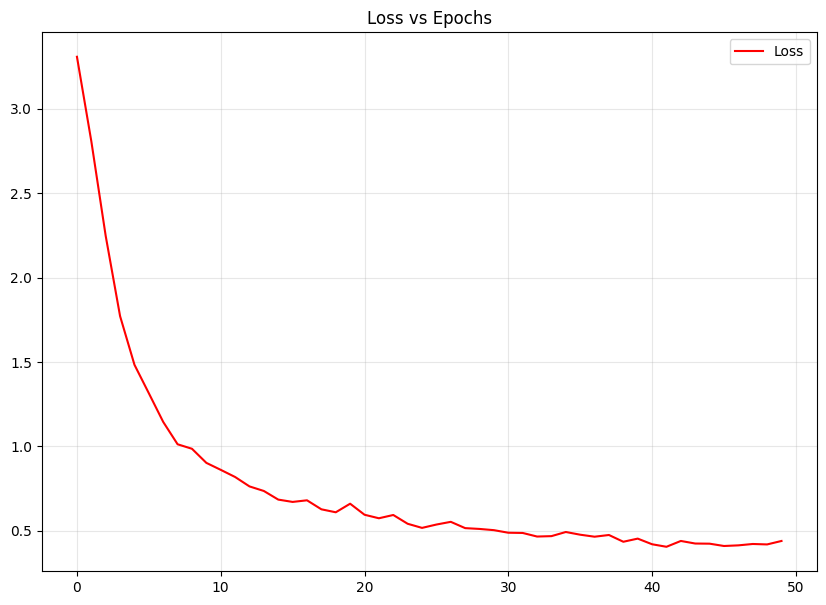

1/1 [==============================] - 0s 57ms/step
The predicted label for the image is: Mehran_Modiri


In [26]:
label_encoder = train_mlp_model(output_file, model_save_path)

# Predict a New Image
new_image_path = r"/content/photo.jpg"
predicted_label = predict_image(model_save_path, label_encoder, new_image_path)
print(f"The predicted label for the image is: {predicted_label}")